In [4]:
from collections import defaultdict
from process_childes import *
from gensim.models import Word2Vec

In [5]:
def extract_dep_pairs(utterance, gra_line):
    words = utterance.strip().split()
    pairs = []
    try:
        deps = gra_line.strip().split()
        for dep in deps:
            child_idx, head_idx, label = dep.split("|")
            child_idx = int(child_idx) - 1
            head_idx = int(head_idx) - 1

            if 0 <= child_idx < len(words):
                child = words[child_idx]
                if head_idx == -1:
                    continue  # root
                if 0 <= head_idx < len(words):
                    head = words[head_idx]
                    # Forward
                    pairs.append((child, f"{label}:{head}"))
                    # Reverse
                    pairs.append((head, f"{label}^-1:{child}"))
    except:
        pass
    return pairs


In [6]:
def build_dependency2vec_corpus(data):
    corpus = []

    # Process children (by age)
    for age, utterance_list in data["child"].items():
        for utterance, gra in utterance_list:
            pairs = extract_dep_pairs(utterance, gra)
            corpus.extend(pairs)

    # Process adults
    for utterance, gra in data["adult"]:
        pairs = extract_dep_pairs(utterance, gra)
        corpus.extend(pairs)

    return corpus


In [7]:
# Step 1: Get all utterance/gra tuples
data = clean_chinese_utterances(get_all_utterance_gra_by_group_folder("Mandarin"))

# Step 2: Build word-context pairs
corpus = build_dependency2vec_corpus(data)

# Step 3: Save to file
with open("dependency2vec_corpus_clean.txt", "w", encoding="utf-8") as f:
    for word, context in corpus:
        f.write(f"{word}\t{context}\n")

In [8]:
def prepare_sentences_for_word2vec(corpus):
    # Each sentence is a pair turned into a list: [word, context]
    return [[word, context] for word, context in corpus]

sentences = prepare_sentences_for_word2vec(corpus)


In [9]:
model = Word2Vec(
    sentences=sentences,
    vector_size=100,     # size of embedding
    window=5,            # context window size (not used directly here)
    min_count=1,         # keep all
    sg=1,                # skip-gram
    workers=4,
    epochs=10
)

In [10]:
model.save("dependency2vec-clean.model")

In [11]:
model.wv.most_similar("把")


[('由', 0.6712636947631836),
 ('為', 0.6571581959724426),
 ('按照', 0.6402274966239929),
 ('全部', 0.6383758187294006),
 ('被', 0.6258779764175415),
 ('只好', 0.6090978980064392),
 ('連', 0.6079245805740356),
 ('飛快地', 0.6019395589828491),
 ('將', 0.6008935570716858),
 ('替', 0.5990582704544067)]

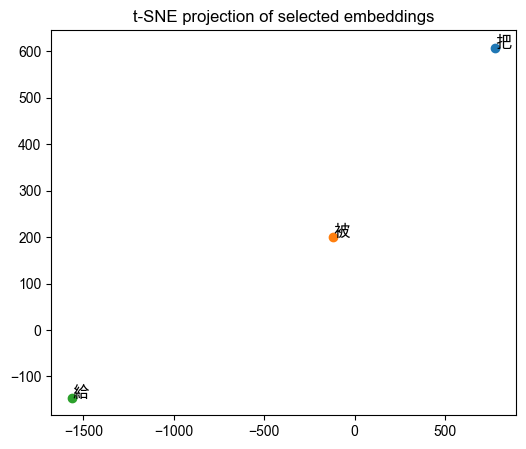

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'Arial Unicode MS'  # macOS

words = ['把', '被', '給']  # Traditional Chinese
vectors = [model.wv[word] for word in words if word in model.wv]

if vectors:  # Only run if at least one word is found
    X = np.array(vectors)

    tsne = TSNE(n_components=2, perplexity=1, random_state=42)
    points = tsne.fit_transform(X)


    plt.figure(figsize=(6, 5))
    for i, word in enumerate(words):
        if word in model.wv:
            plt.scatter(*points[i])
            plt.text(points[i, 0] + 0.01, points[i, 1] + 0.01, word, fontsize=12)
    plt.title("t-SNE projection of selected embeddings")
    plt.show()
else:
    print("None of the words found in the model vocabulary.")

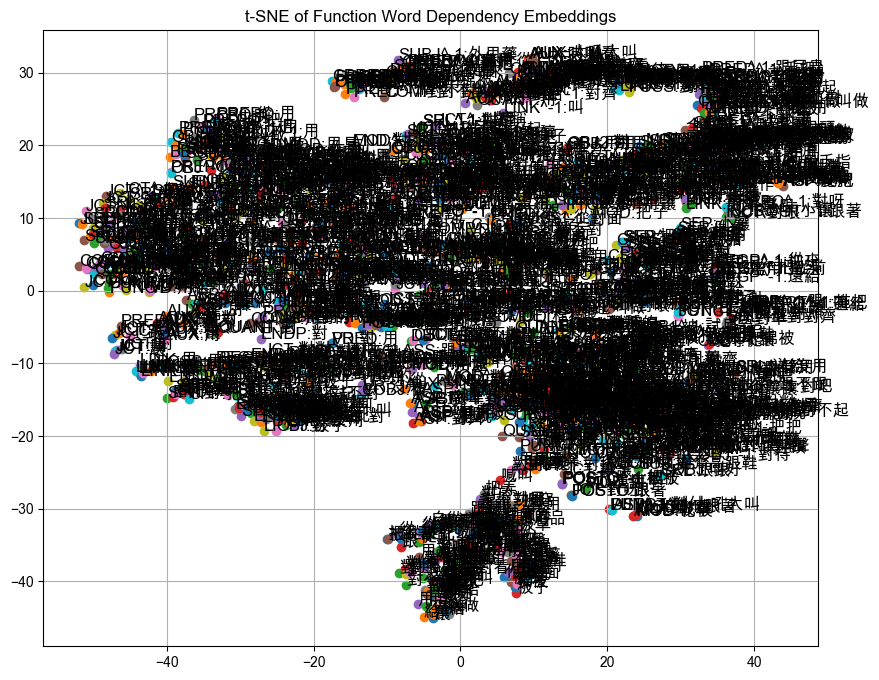

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Target base words
base_words = ['把', '被', '給', '從', '對', '跟', '讓', '叫', '用']

# Collect valid words including variants like <把, 給1, etc.
all_keys = model.wv.key_to_index.keys()
valid_words = [w for w in all_keys if any(base in w for base in base_words)]

# Skip if too few words
if len(valid_words) < 2:
    print("Not enough valid words found in the model.")
else:
    # Get vectors and convert to NumPy array
    vectors = np.array([model.wv[w] for w in valid_words])

    # Run t-SNE
    tsne = TSNE(n_components=2, random_state=0, perplexity=min(len(valid_words) - 1, 30))
    coords = tsne.fit_transform(vectors)

    # Plot with Chinese font support
    plt.figure(figsize=(10, 8))
    plt.rcParams['font.family'] = 'Arial Unicode MS'  # macOS; replace if needed

    for i, word in enumerate(valid_words):
        x, y = coords[i]
        plt.scatter(x, y)
        plt.text(x + 0.01, y + 0.01, word, fontsize=12)

    plt.title("t-SNE of Function Word Dependency Embeddings")
    plt.grid(True)
    plt.show()


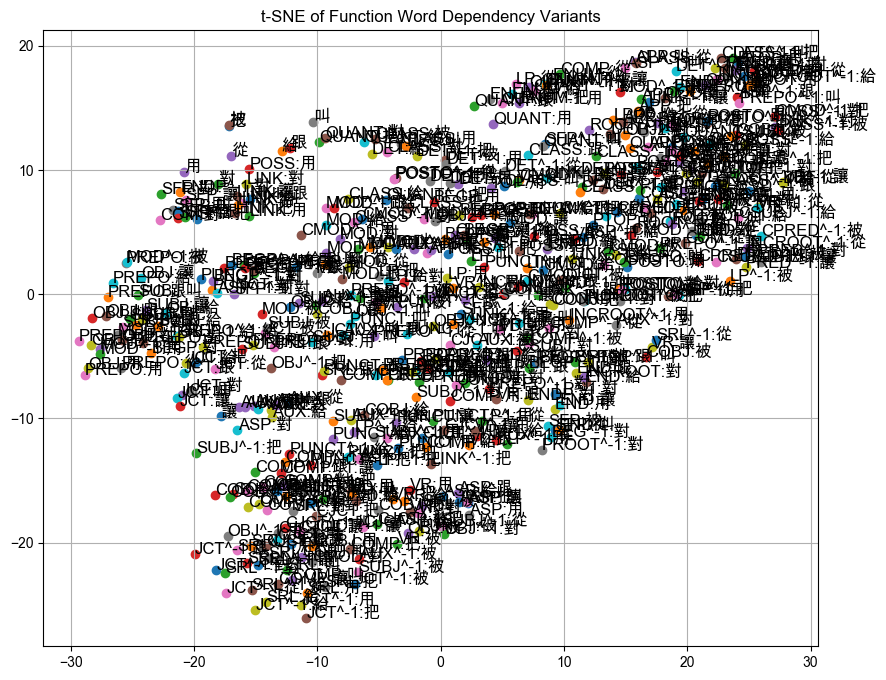

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import re

# Base words of interest
base_words = ['把', '被', '給', '從', '對', '跟', '讓', '叫', '用']

# Regex: keep only those that are (1) exactly the base word or (2) contain ASCII/non-CJK + the base word
def is_valid_variant(word):
    for base in base_words:
        if word == base:
            return True
        if re.fullmatch(r'[^\u4e00-\u9fff]*' + re.escape(base) + r'\d*', word):
            return True
    return False

# Filter keys
all_keys = model.wv.key_to_index.keys()
valid_words = [w for w in all_keys if is_valid_variant(w)]

# Guard clause
if len(valid_words) < 2:
    print("Too few valid words for t-SNE.")
else:
    vectors = np.array([model.wv[w] for w in valid_words])

    tsne = TSNE(n_components=2, random_state=0, perplexity=min(len(valid_words) - 1, 30))
    coords = tsne.fit_transform(vectors)

    plt.figure(figsize=(10, 8))
    plt.rcParams['font.family'] = 'Arial Unicode MS'  # macOS; change if needed

    for i, word in enumerate(valid_words):
        x, y = coords[i]
        plt.scatter(x, y)
        plt.text(x + 0.01, y + 0.01, word, fontsize=12)

    plt.title("t-SNE of Function Word Dependency Variants")
    plt.grid(True)
    plt.show()


Valid variants: 12


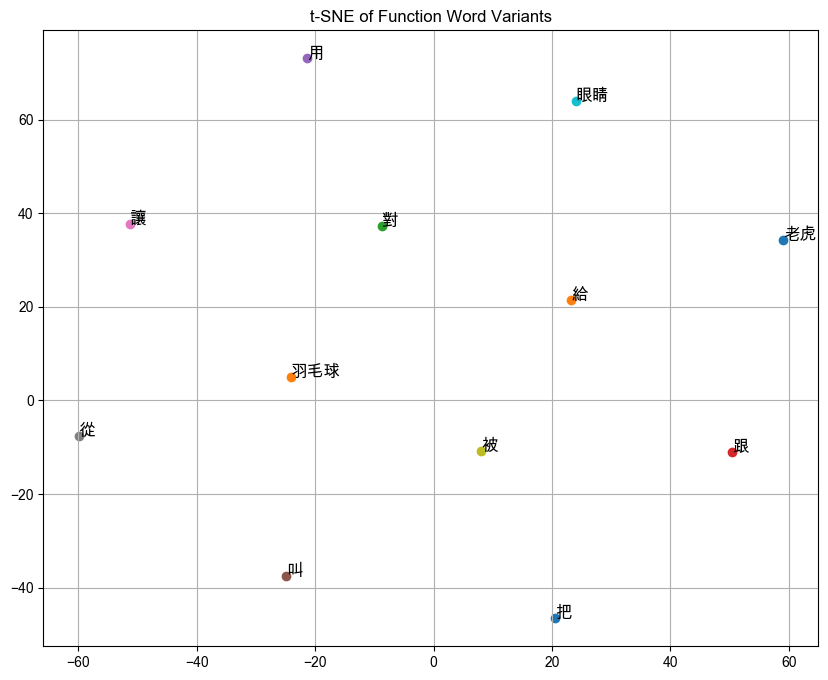

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import re

# Base words of interest
base_words = ['把', '被', '給', '從', '對', '跟', '讓', '叫', '用', '老虎', '眼睛', '羽毛球']

# Regex: only allow <=2 non-CJK chars before/after the base word, no other Chinese chars
def is_valid_variant(word):
    for base in base_words:
        pattern = rf'^[^\u4e00-\u9fff]{{0,2}}{re.escape(base)}[^\u4e00-\u9fff]{{0,2}}$'
        if re.fullmatch(pattern, word):
            return True
    return False

# Filter keys
all_keys = model.wv.key_to_index.keys()
valid_words = [w for w in all_keys if is_valid_variant(w)]

print(f"Valid variants: {len(valid_words)}")  # sanity check

if len(valid_words) < 2:
    print("Too few valid words for t-SNE.")
else:
    vectors = np.array([model.wv[w] for w in valid_words])

    tsne = TSNE(n_components=2, random_state=0, perplexity=min(len(valid_words) - 1, 30))
    coords = tsne.fit_transform(vectors)

    plt.figure(figsize=(10, 8))
    plt.rcParams['font.family'] = 'Arial Unicode MS'  # macOS font; change if needed

    for i, word in enumerate(valid_words):
        x, y = coords[i]
        plt.scatter(x, y)
        plt.text(x + 0.01, y + 0.01, word, fontsize=12)

    plt.title("t-SNE of Function Word Variants")
    plt.grid(True)
    plt.show()


In [18]:
model.wv.most_similar(positive=['給', '被'], negative=['把'])

[('替', 0.5858403444290161),
 ('為', 0.5481831431388855),
 ('趁', 0.5403848886489868),
 ('隨', 0.5231369733810425),
 ('上校', 0.4894944429397583),
 ('趁著', 0.4872312843799591),
 ('自從', 0.4794620871543884),
 ('跟', 0.47510766983032227),
 ('直到', 0.4702144265174866),
 ('驚', 0.46637865900993347)]